In [1]:
import numpy as np
import jax
import jax.numpy as jnp

from deep_parity.jax.model import Perceptron
from deep_parity.jax.boolean_cube import fourier_transform, generate_all_binary_arrays

from pathlib import Path

import polars as pl
from plotnine import ggplot, qplot, aes, geom_point, geom_histogram, facet_wrap, labs

from google.cloud import storage
import equinox as eqx


def try_load_checkpoint(model_template, bucket_name, config, step):
    """Try to load the latest checkpoint from GCS bucket"""
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    
    # Find checkpoints
    n = config['model']['n']
    seed = config['seed']

    checkpoint_dir = f"checkpoints-one-layer-n={n}-seed={seed}"
    blobs = list(bucket.list_blobs(prefix=f"{checkpoint_dir}/{step}/model_"))
    
    if not blobs:
        print("No checkpoints found, starting fresh training")
        return None
    
   
    
    # Download latest checkpoint files
    model_blob = bucket.blob(f"{checkpoint_dir}/{step}/model_{step}.eqx")
    model_local_path = f"/tmp/model_{step}.eqx"
    model_blob.download_to_filename(model_local_path)
    
    #opt_blob = bucket.blob(f"{checkpoint_dir}/opt_{latest_step}.eqx")
    #opt_local_path = f"/tmp/opt_{latest_step}.eqx"
    #opt_blob.download_to_filename(opt_local_path)
    
    #rng_blob = bucket.blob(f"{checkpoint_dir}/rng_{latest_step}.eqx")
    #rng_local_path = f"/tmp/rng_{latest_step}.npy"
    #try:
    #    rng_blob.download_to_filename(rng_local_path)
    #except:
    #    # If RNG file doesn't exist, create a new key
    #    print("RNG key not found, creating new one")
    #    rng_key = jax.random.PRNGKey(config['seed'])
    #else:
    #    with open(rng_local_path, "rb") as f:
    #        rng_key = np.load(f)
    
    # Deserialize model and optimizer state
    model = eqx.tree_deserialise_leaves(model_local_path, model_template)
    
    # Initialize optimizer state with the model template to get the structure
    #dummy_opt_state = optimizer.init(eqx.filter(model_template, eqx.is_inexact_array))
    #opt_state = eqx.tree_deserialise_leaves(opt_local_path, dummy_opt_state)
    
    return model





In [47]:
n = 20
model_dim = 2048
step = 1000
seed = 1

config = {'model': {'n': n, 'model_dim': model_dim}, 'seed': 1}

bucket_name = "deep-parity-training-0"
checkpoint_dir = f"checkpoints-1layer-{n}"

key = jax.random.key(0)

template = Perceptron(n, model_dim, key)

model = try_load_checkpoint(template, bucket_name, config, step)




In [48]:
import random

idx = random.randint(0, 2047)
w = model.linear.weight[idx]
min_val = jnp.abs(w).min()
sorted_inds = jnp.argsort(jnp.abs(w))
print(w[sorted_inds] / min_val)



[ -1.          2.4528708   5.4751525   7.4471416  -9.357474   14.977544
 -16.211834   20.94152   -29.872444   34.21726    35.54416    39.20078
  40.05447    43.556725   44.142788   44.97217    50.395576   51.01066
 -53.21667    59.440422 ]


In [49]:
import random

key, subkey = jax.random.split(key)

idx = random.randint(0, 2047)
w = jax.random.normal(subkey, (20,))
min_val = jnp.abs(w).min()
sorted_inds = jnp.argsort(jnp.abs(w))
print(w[sorted_inds] / min_val)

[ -1.         -2.7372859   2.967908    4.2908516  -5.10499    -5.3858037
   6.3935657 -10.810442  -11.002253  -13.8047905  13.919608  -16.579433
 -17.017265  -17.186958  -18.786743  -18.923103  -28.283258  -29.394041
  30.758549  -35.267212 ]


In [50]:

def integer_proximity(numbers):
    # Calculate distance to nearest integer for each number
    distances = jnp.abs(jnp.round(numbers) - numbers)
    
    # Various metrics
    mean_distance = jnp.mean(distances, axis=1)
    rms_distance = jnp.sqrt(jnp.mean(jnp.square(distances), axis=1))
    max_distance = jnp.max(distances, axis=1)
    
    return {
        "mean_distance": mean_distance,
        "rms_distance": rms_distance,
        "max_distance": max_distance
    }



In [51]:


df = pl.DataFrame(jax.tree.map(lambda x: np.array(x), integer_proximity(model.linear.weight)))

In [52]:
data = []
for step in range(1000, 51000, 1000):
    model = try_load_checkpoint(template, bucket_name, config, step)
    df = pl.DataFrame(jax.tree.map(lambda x: np.array(x), integer_proximity(model.linear.weight)))
    df = df.with_columns(step=pl.lit(step)).with_row_index()
    data.append(df)

integral_df = pl.concat(data, how='vertical').unpivot(index=['step', 'index'])

In [83]:
least_integral_df = (
    integral_df
    .filter(pl.col('variable').eq('rms_distance'))
    .group_by('step')
    .agg(
        least_integral=pl.col('index').top_k_by('value', 100).implode(),
        most_integral=pl.col('index').bottom_k_by('value', 100).implode())
    .sort('step')
)
least_integral_indices = least_integral_df['least_integral'].to_list()[0][0]
least_integral_df

step,least_integral,most_integral
i32,list[list[u32]],list[list[u32]]
1000,"[[1841, 1694, … 418]]","[[606, 111, … 659]]"
2000,"[[1694, 305, … 1030]]","[[606, 111, … 1184]]"
3000,"[[1694, 305, … 591]]","[[737, 949, … 895]]"
4000,"[[1694, 305, … 185]]","[[1722, 1063, … 1207]]"
5000,"[[1694, 305, … 778]]","[[1063, 27, … 260]]"
…,…,…
46000,"[[305, 1694, … 1519]]","[[1063, 1859, … 1140]]"
47000,"[[305, 1694, … 729]]","[[1063, 1859, … 1140]]"
48000,"[[305, 1694, … 729]]","[[1063, 1859, … 1140]]"


/home/dstander/deep-parity/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 87'. Pick better value with 'binwidth'.


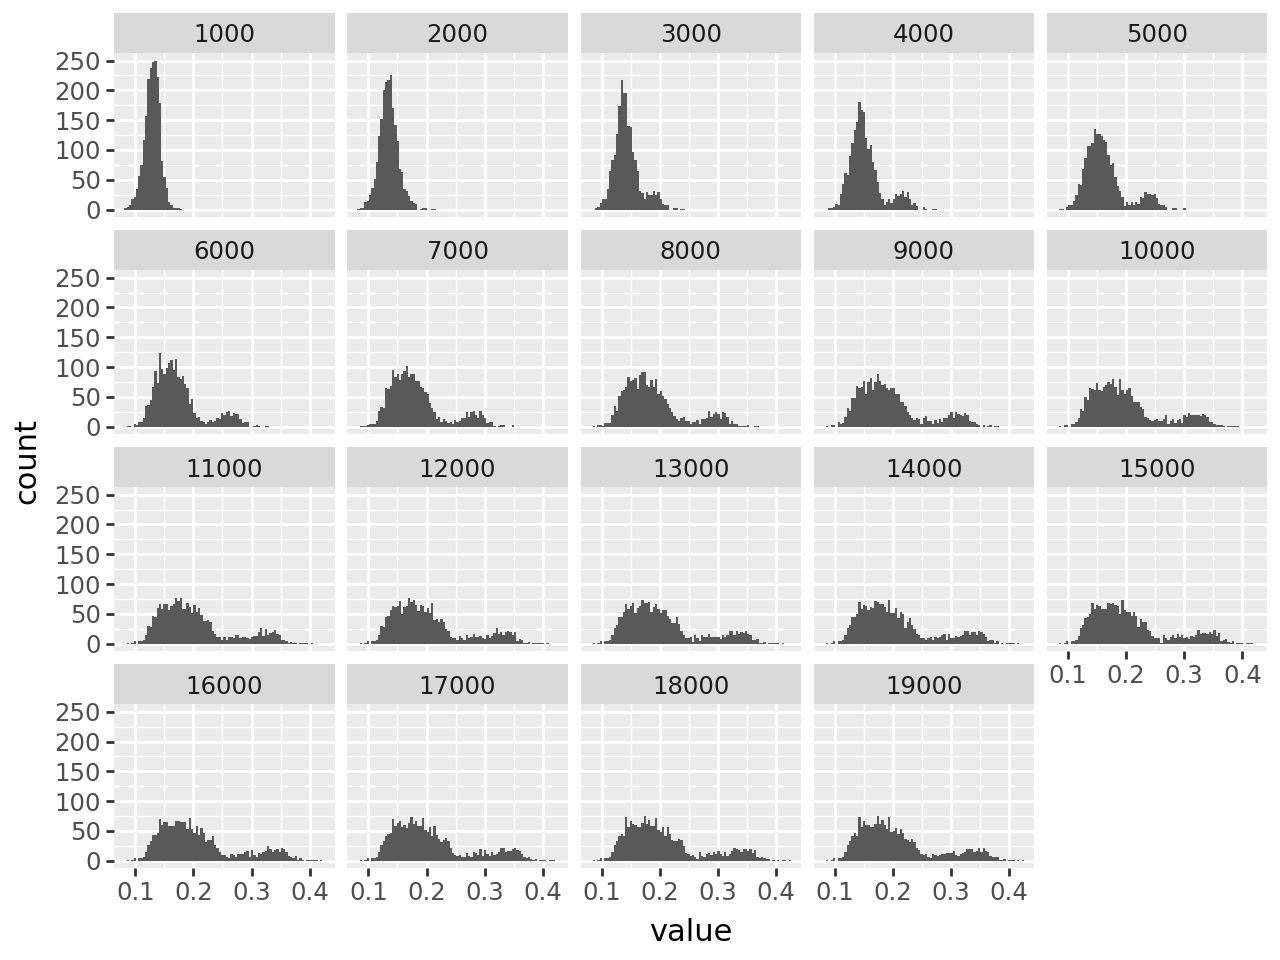

In [54]:

ggplot(integral_df.filter(pl.col('variable').eq('rms_distance')).filter(pl.col('step') < 20_000), aes(x='value')) + geom_histogram() + facet_wrap('~step')



In [59]:
w = model.linear.weight[1063]
w /= jnp.abs(w).min()
w


Array([-12.532241 ,   1.1883148,  10.201176 ,   1.1944492,  -7.897953 ,
       -12.536243 ,  -5.7297616,  -3.3222394,   1.2189453,   5.6909466,
         5.7965074,  -1.2161019, -12.5576   ,  -1.2657564, -12.54254  ,
         3.443496 ,  -5.5762854,  10.143881 ,   1.       ,  -1.0177622],      dtype=float32)

In [86]:
from random import choice
idx = choice(least_integral_indices)
print(idx)
print(model.linear.weight[idx])

1770
[-0.2348633  -0.08328845 -0.0837879  -0.23388672  0.23388672 -0.2331328
  0.23388675 -0.0838337  -0.23388676  0.23388673 -0.23388672  0.23388672
  0.23354255 -0.08425676  0.08384     0.23458906 -0.23331696 -0.23388672
 -0.23456945  0.23362266]


In [90]:
model.linear.weight[idx] / 0.083

Array([-2.8296783, -1.0034753, -1.0094928, -2.8179123,  2.8179123,
       -2.8088288,  2.8179126, -1.0100446, -2.8179128,  2.8179126,
       -2.8179123,  2.8179123,  2.8137658, -1.0151417,  1.0101205,
        2.8263743, -2.8110478, -2.8179123, -2.826138 ,  2.814731 ],      dtype=float32)

In [115]:
jnp.unique_counts(jnp.abs(jnp.round(model.linear.weight[idx], 2)), size=20, fill_value=-1)

_UniqueCountsResult(values=Array([ 0.08      ,  0.22999999, -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ],      dtype=float32), counts=Array([ 5, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32))

In [116]:
@jax.vmap
def num_unique(x):
    _, counts = jnp.unique_counts(x, size=20, fill_value=-1)
    gt1 = (counts > 1).astype(float)
    return jnp.inner(counts, gt1) / 20


df = pl.DataFrame({
    '2': np.array(num_unique(jnp.abs(jnp.round(model.linear.weight, 2)))),
    '3': np.array(num_unique(jnp.abs(jnp.round(model.linear.weight, 3)))),
    '4': np.array(num_unique(jnp.abs(jnp.round(model.linear.weight, 4))))
})

In [117]:
df

2,3,4
f32,f32,f32
1.0,1.0,0.75
1.0,1.0,0.7
0.55,0.2,0.0
1.0,1.0,0.55
0.3,0.0,0.0
…,…,…
0.3,0.0,0.0
0.65,0.2,0.0
0.7,0.3,0.1


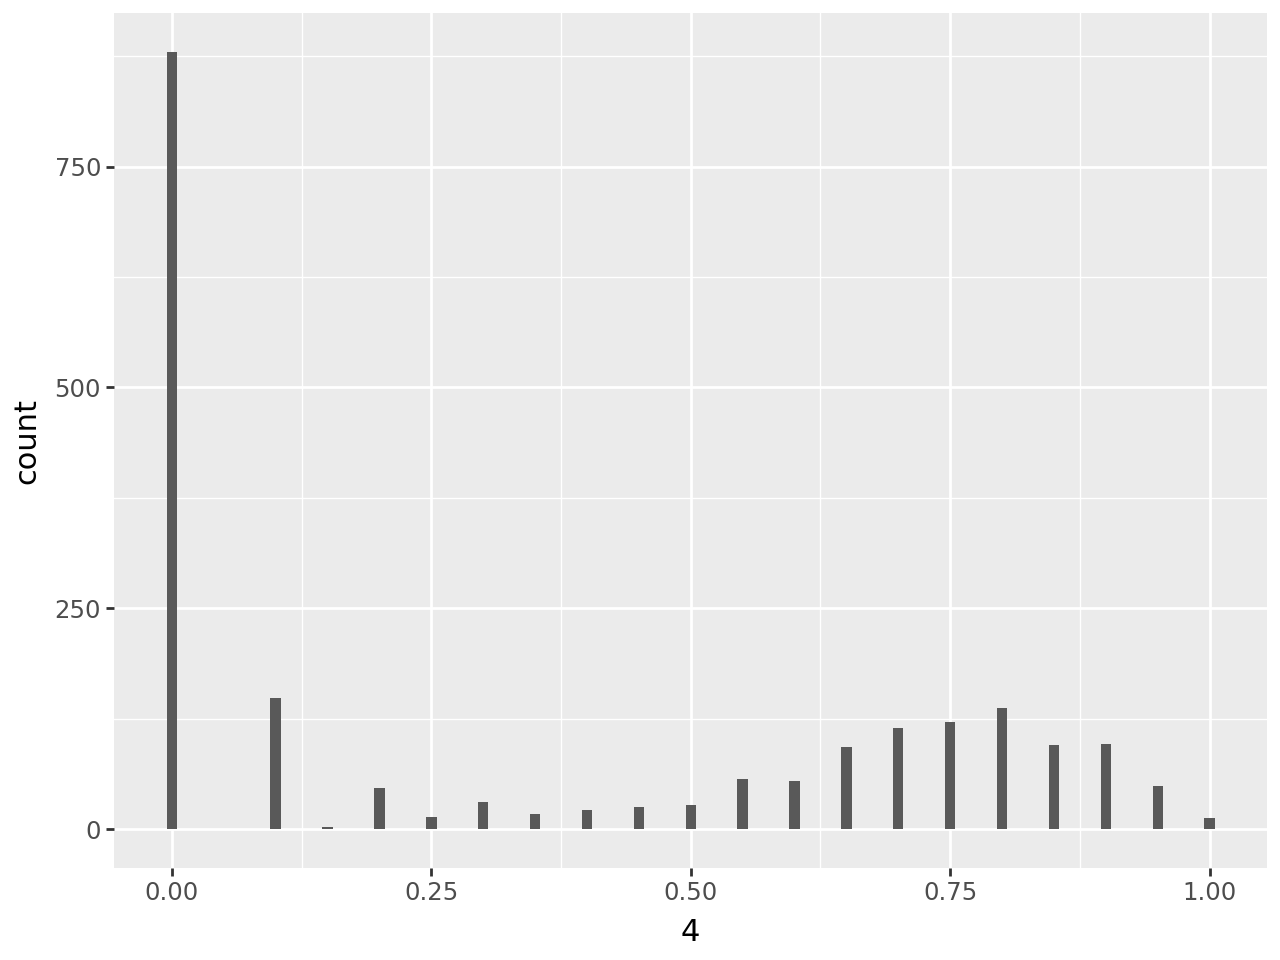

In [123]:
ggplot(df, aes(x='4')) + geom_histogram(binwidth=0.01)